In [1]:
import sqlite3 as db 
import pandas as pd
conn = db.connect('soccer/database.sqlite')

##
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
norm_team_name = {}
norm_team_name['Man United'] = 'Manchester United'
norm_team_name['Man City'] = 'Manchester City'
norm_team_name['QPR'] = 'Queens Park Rangers'
norm_team_name['West Brom'] = 'West Bromwich Albion'
norm_team_name['West Ham'] = 'West Ham United'
norm_team_name['Bournemouth'] = 'AFC Bournemouth'

year_data = {'2014': 'statbunker-football-stats/Player Stats 2014-15.csv' , 
             '2015': 'statbunker-football-stats/Player Stats 2015-16.csv' ,
             '2016': 'statbunker-football-stats/Player Stats 2016-17.csv'}


In [3]:
def get_all_players_info(year):
    query_str = """select  p.player_name,pa2.* from player_attributes pa2, player p where p.player_api_id = pa2.player_api_id and
    (pa2.player_api_id, pa2.date) in (
    select z.player_api_id, z.date from (
    select pa.player_api_id, pa.date, min(abs(strftime('%%s',pa.date) - strftime('%%s','%(year)s-09-01 00:00:00'))) from player_attributes pa, player p 
                                    where pa.player_api_id = p.player_api_id
                                    and strftime('%%s',pa.date) > strftime('%%s','2014-05-14 00:00:00') 
                                    and pa.date like '%(year)s%%'
                                    group by pa.player_api_id ) z )"""%{'year':year}
    
    all_player_attrs = pd.read_sql_query(query_str,conn)
    
    return all_player_attrs


In [4]:
def norm_player_names(all_players_info):
    
    for key,value in norm_team_name.items():
        all_players_info.loc[lambda df: df['HomeTeam'] == key, 'HomeTeam'] = value
        all_players_info.loc[lambda df: df['AwayTeam'] == key, 'AwayTeam'] = value
    
    return all_players_info

In [5]:
def get_full_data(year):
    ptm = pd.read_csv(year_data[year] , dtype = {'overall_rating':float} )
   
    ptm = ptm[(ptm['Type Of Goal'] == 'Player') & (ptm['League'] == 'Premier League')]
    
    all_players_info  = get_all_players_info(year)
        
    joined = all_players_info.set_index('player_name').join(ptm.set_index('Player'), how='inner')
    return joined

In [6]:
def create_team(data, name):
    
    full_team = data[data['Team'].str.startswith(name)]
        
    team_agg = {}
    
    team_df = {}
    
    df_start = full_team[full_team['Team'] == 'THIS DOES NOT EXIST']
    
    pos_sel = {'Defender': 4, 'Midfielder': 4, 'Forward': 2, 'Goalkeeper':1}

    
    
#     if (len(df_start[df_start['Position'] == 'Forward']) < 3 ):
#         forwards = len(df_start[df_start['Position'] == 'Forward'])
#         print(forwards)
#         pos_sel['Forward'] = forwards
#         pos_sel['Midfielder'] = 6 - forwards

    for key,value in pos_sel.items():
        
        grp = full_team[full_team['Position'] == key].sort_values(by = ['overall_rating'], ascending = False).head(value)
        df_start = df_start.append(grp)
        avg = grp.mean()
        team_agg[key] = avg
    
    return df_start

In [7]:
def agg_attributes(team):
    #team[team['Position'] == 'Goalkeeper']['Position'] = 'Defender'
    
    team.loc[lambda df: df['Position'] == 'Goalkeeper', 'Position'] = 'Defender'
       
    
    g = team.groupby(['Position'] , as_index=False).mean()
    #print(g['overall_rating'])
    #g = g.reset_index().set_index('index')
    
    return g.transpose()

In [8]:
def get_fixtures(year):
    f = pd.read_csv('epl-results-19932018/EPL_Set.csv')
    f = norm_player_names(f)
    
    return f[f['Season'].str.startswith(year)]
    


In [55]:
def combine_metrics_2(row, home_attrs,away_attrs,i):
    ### D - D , A - A ###
    norm_attrs = {}
    norm_attrs['Home_Def'] = home_attrs[0]['overall_rating']
    norm_attrs['Home_Att'] = home_attrs[1]['overall_rating']
    norm_attrs['Home_Mid'] = home_attrs[2]['overall_rating']
    
    norm_attrs['Away_Def'] = away_attrs[0]['overall_rating']
    norm_attrs['Away_Att'] = away_attrs[1]['overall_rating']
    norm_attrs['Away_Mid'] = away_attrs[2]['overall_rating']

    norm_attrs['Def_Score'] = home_attrs[0]['overall_rating'] - away_attrs[0]['overall_rating']
    norm_attrs['Att_Score'] = home_attrs[1]['overall_rating'] - away_attrs[1]['overall_rating']
    norm_attrs['Mid_Score'] = home_attrs[2]['overall_rating'] - away_attrs[2]['overall_rating']
    norm_attrs['Result'] = 1 if row['FTHG'] - row['FTAG'] > 0  else (-1 if row['FTHG'] - row['FTAG'] < 0 else 0)
    
    norm_df = pd.DataFrame(norm_attrs, index = [str(i)])
    
    return norm_df

def combine_metrics_1(row,home_attrs,away_attrs,i):
    """ D-A  """
    norm_attrs = {}
    
    norm_attrs['Home_Def'] = home_attrs[0]['overall_rating']
    norm_attrs['Home_Att'] = home_attrs[1]['overall_rating']
    norm_attrs['Home_Mid'] = home_attrs[2]['overall_rating']
    
    norm_attrs['Away_Def'] = away_attrs[0]['overall_rating']
    norm_attrs['Away_Att'] = away_attrs[1]['overall_rating']
    norm_attrs['Away_Mid'] = away_attrs[2]['overall_rating']
    
    norm_attrs['Def_Score'] = home_attrs[0]['overall_rating'] - away_attrs[1]['overall_rating']
    norm_attrs['Att_Score'] = home_attrs[1]['overall_rating'] - away_attrs[0]['overall_rating']
    norm_attrs['Mid_Score'] = home_attrs[2]['overall_rating'] - away_attrs[2]['overall_rating']
    norm_attrs['Result'] = 1 if row['FTHG'] - row['FTAG'] > 0  else (-1 if row['FTHG'] - row['FTAG'] < 0 else 0)
    
    norm_df = pd.DataFrame(norm_attrs, index = [str(i)])
    
    return norm_df

In [56]:
def get_all_team_data(year):
    
    data = {}

    joined_data = get_full_data(year)

    f = get_fixtures(year)
    teams = f['HomeTeam'].unique()

    for team in teams:
        team_data = create_team(joined_data, team)
        team_attr = agg_attributes(team_data)
        data[team] = (team_data, team_attr)

    return data

In [11]:
def attr_normalize(df, attr,column):
        
    mx = max(df[column])
    mn = min(df[column])
    diff = (mx) - (mn)
    return df[attr].apply(lambda x : x/diff)



In [12]:
def construct_training_data(years):
    
    full_res_df = pd.DataFrame()
    
    for year in years:
        
        team_store = get_all_team_data(year)
        i = 0
        res_df = pd.DataFrame()
        f = get_fixtures(year)
        for key,row in f.iterrows():
        #     print("MATCHING UP: %s vs %s"%(row['HomeTeam'], row['AwayTeam']))
            home = row['HomeTeam']
            away = row['AwayTeam']

            home_attrs = team_store[home][1]
            away_attrs = team_store[away][1]

            res_df = res_df.append(combine_metrics_2(row,home_attrs,away_attrs,i))

            i = i + 1
        
        res_df['Att_Score'] = attr_normalize(res_df, 'Att_Score','Home_Att' )
        res_df['Def_Score'] = attr_normalize(res_df, 'Def_Score','Home_Def' )
        res_df['Mid_Score'] = attr_normalize(res_df, 'Mid_Score','Home_Mid' )
        res_df['Total'] = (res_df['Att_Score'] + res_df['Def_Score'] + res_df['Mid_Score'])/3
        res_df.pop('Home_Att')
        res_df.pop('Home_Mid')
        res_df.pop('Home_Def')
        res_df.pop('Away_Att')
        res_df.pop('Away_Mid')
        res_df.pop('Away_Def')

        
        full_res_df = full_res_df.append(res_df)

    return full_res_df

In [13]:
tr_data = construct_training_data(['2014','2015','2016'])

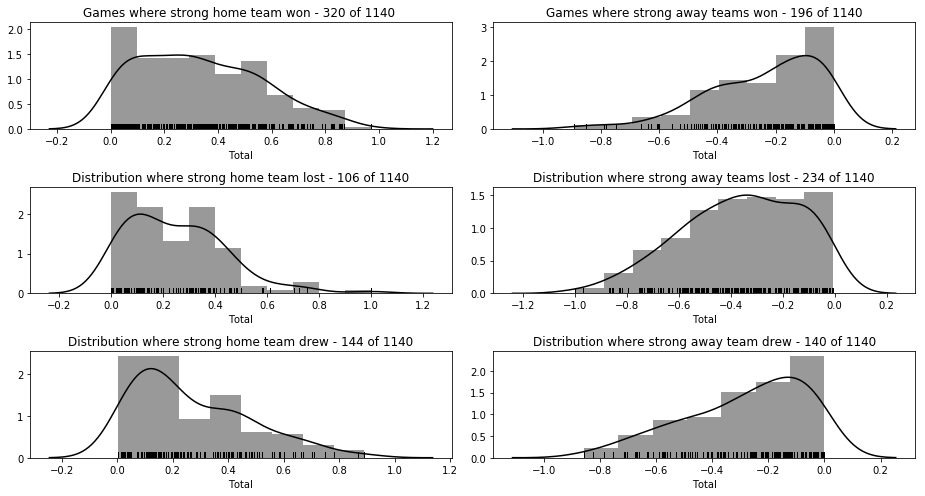

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

attribute = 'Total'

strong_home_winners = tr_data[(tr_data['Total'] > 0) & (tr_data['Result'] == 1)]

strong_home_losers= tr_data[(tr_data['Total'] > 0) & (tr_data['Result'] == -1)]

strong_home_draw = tr_data[(tr_data['Total'] > 0) &  (tr_data['Result'] == 0)]


strong_away_winners = tr_data[(tr_data['Total'] < 0) & (tr_data['Result'] == 1)]

strong_away_losers = tr_data[(tr_data['Total'] < 0) & (tr_data['Result'] == -1)]

strong_away_draw = tr_data[(tr_data['Total'] < 0) &  (tr_data['Result'] == 0)]


disp_attrs = {'hist': True, 'kde': True, 'norm_hist':True, "color" : 'black', 'rug':True}


f, axes = plt.subplots(3, 2, figsize=(13, 7), sharex=False)

sns.distplot(strong_home_winners[attribute],**disp_attrs, ax = axes[0,0] )
axes[0,0].set_title( 'Games where strong home team won - %s of 1140 '%str(len(strong_home_winners['Att_Score'])))

sns.distplot(strong_home_losers[attribute],**disp_attrs, ax = axes[1,0])
axes[1,0].set_title( 'Distribution where strong home team lost - %s of 1140'%str(len(strong_home_losers['Att_Score'])))

sns.distplot(strong_home_draw[attribute],**disp_attrs, ax = axes[2,0])
axes[2,0].set_title( 'Distribution where strong home team drew - %s of 1140'%str(len(strong_home_draw['Att_Score'])))

sns.distplot(strong_away_winners[attribute],**disp_attrs,ax = axes[0,1] )
axes[0,1].set_title( 'Games where strong away teams won - %s of 1140'%str(len(strong_away_winners['Att_Score'])))

sns.distplot(strong_away_losers[attribute],**disp_attrs, ax = axes[1,1])
axes[1,1].set_title( 'Distribution where strong away teams lost - %s of 1140'%str(len(strong_away_losers['Att_Score'])))

sns.distplot(strong_away_draw[attribute],**disp_attrs, ax = axes[2,1])
axes[2,1].set_title( 'Distribution where strong away team drew - %s of 1140'%str(len(strong_away_draw['Att_Score'])))


plt.tight_layout()


# for key, row in tr_data.iterrows():
    
#     if (row['Def_Score'] > 0 and row['Result'] == 1) or (row['Def_Score'] < 0 and row['Result'] == -1):
#         color = ''
        
#     elif row['Result'] == 0:
#         color = ''
#     else:
#         color = 'bx'
 
#     plt.plot(key, row['Att_Score'], color)

# plt.show()
# attr = ['Att_Score','Def_Score','Mid_Score']




# for a in enumerate(attr):
#     print("Based on attribute %s"%a)
#     strong_winners_home = tr_data[(tr_data[a] > 0) & (tr_data['Result'] == 1)]
#     strong_winners_away = tr_data[(tr_data[a] < 0) & (tr_data['Result'] == -1)]

    
#     plt.plot(i,tr_data['Att_Score'],'bo',label = 'Test')
#     strong_draw_home = tr_data[(tr_data[a] > 0) & (tr_data['Result'] == 0)]
#     strong_draw_away = tr_data[(tr_data[a] < 0) & (tr_data['Result'] == 0)]
    
#     weak_winner_home = tr_data[(tr_data[a] > 0) & (tr_data['Result'] == -1)]
#     weak_winner_away = tr_data[(tr_data[a] < 0) & (tr_data['Result'] == 1)]
 
# #     print(len(strong_winners_away) + len(strong_winners_home) )

# #     #print(strong_winners_home
# #     print(len(strong_draw_home) + len(strong_draw_away))
    
# #     print(len(weak_winner_away) + len(weak_winner_home) )
    
    
# #plt.show()





In [18]:
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

2.2.4


In [52]:
def create_model(x_train,y_train):
    """ Creates a Sequential model made out of Densely connected Neural Network layers. All parameters are configured as per specification for Q4"""

    model = Sequential()
    #Input Layer with 61 inputs corresponding to 61 features 
    
    model.add(Dense(1,input_dim=3,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='softmax'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

    
#     model.add(Dense(20,input_dim = 3, activation = 'relu'))

#     model.add(Dense(128,activation = 'relu'))

#     model.add(Dense(1,activation = 'sigmoid'))
  
#     #Compiling the model with appropriate parameters
#     model.compile(loss = 'mse', optimizer ='adam',metrics = ['accuracy'])

    result = model.fit(x_train,y_train,epochs = 50, batch_size = 50)

    #Store the model, its average training accuracy and validation accuracy over 10 epochs

    return model


In [53]:
from sklearn.model_selection import train_test_split

full_copy = tr_data.copy()
print(full_copy)
full_copy.pop('Total')
full_y = full_copy.pop('Result')
full_x = full_copy

x_train,te_x,y_train,te_y = train_test_split(full_x, full_y, test_size = 0.25, stratify = full_y)



     Att_Score  Def_Score  Mid_Score  Result     Total
0     0.450000   0.551724   0.542373       1  0.514699
1    -0.625000  -0.413793  -0.491525       0 -0.510106
2     0.425000   0.379310   0.576271      -1  0.460194
3    -0.025000   0.120690   0.101695      -1  0.065795
4     0.025000   0.068966   0.050847      -1  0.048271
5    -0.075000   0.120690   0.033898       0  0.026529
6    -0.325000  -0.637931  -0.186441      -1 -0.383124
7     0.300000   0.431034   0.186441       1  0.305825
8    -0.475000  -0.465517  -0.644068      -1 -0.528195
9    -0.650000  -1.000000  -0.949153      -1 -0.866384
10    0.100000  -0.086207  -0.033898       0 -0.006702
11    0.750000   0.810345   0.830508       1  0.796951
12   -0.025000   0.068966  -0.220339      -1 -0.058791
13   -0.100000  -0.206897  -0.186441       0 -0.164446
14   -0.025000  -0.017241   0.101695       0  0.019818
15    0.475000   0.379310   0.338983       1  0.397764
16   -0.075000  -0.172414   0.016949       0 -0.076822
17   -0.47

In [54]:
#Training neural network
print(len(x_train))
model = create_model(x_train,y_train)
#pred_y = model.predict(te_x)
score = model.evaluate(te_x,te_y)

print(score)

855
Epoch 1/50
855/855 [==============================] - 0s 525us/step - loss: 1.4421 - acc: 0.4526
Epoch 2/50
855/855 [==============================] - 0s 28us/step - loss: 1.4421 - acc: 0.4526
Epoch 3/50
855/855 [==============================] - 0s 33us/step - loss: 1.4421 - acc: 0.4526
Epoch 4/50
855/855 [==============================] - 0s 28us/step - loss: 1.4421 - acc: 0.4526
Epoch 5/50
855/855 [==============================] - 0s 37us/step - loss: 1.4421 - acc: 0.4526
Epoch 6/50
855/855 [==============================] - 0s 28us/step - loss: 1.4421 - acc: 0.4526
Epoch 7/50
855/855 [==============================] - 0s 42us/step - loss: 1.4421 - acc: 0.4526
Epoch 8/50
855/855 [==============================] - 0s 33us/step - loss: 1.4421 - acc: 0.4526
Epoch 9/50
855/855 [==============================] - 0s 37us/step - loss: 1.4421 - acc: 0.4526
Epoch 10/50
855/855 [==============================] - 0s 33us/step - loss: 1.4421 - acc: 0.4526
Epoch 11/50
855/855 [=============

In [ ]:
#Training SVM

In [36]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

svm = LinearSVC(C = 0.1)
svm.fit(x_train,y_train)
# print(svm.coef_)
# print(svm.intercept_)
y_pred = svm.predict(te_x)
z =accuracy_score(te_y,y_pred)
print(z)

0.5087719298245614


In [37]:
#Training decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 5)

dt.fit(x_train['Att_Score'].values.reshape(-1,1),y_train)

y_pred = dt.predict(te_x['Att_Score'].values.reshape(-1,1))

a = accuracy_score(te_y,y_pred)
print(a)
# print(te_y.values)
print(y_pred)

confusion_matrix(y_pred, te_y, labels = [1,0,-1])

# import graphviz 


# dot_data = tree.export_graphviz(dt, out_file='test',feature_names = ['Att_Score'] ,class_names = ['0','-1','1'])

# graphviz.render('dot','png','test', quiet = False)

0.45614035087719296
[ 1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1 -1 -1  1  1  1  1  1  1  1 -1  1  1 -1  0  1  1  1 -1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1  0  1  1  1 -1 -1  1  1  1 -1
  1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1  1 -1 -1  1
  1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1
 -1  1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1
 -1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1
  1 -1  0 -1 -1 -1  0  1  1  1  1 -1  1 -1  1 -1 -1  1  0 -1 -1  1  1  0
 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
  1  1  1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1
  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1  0  1]


array([[85, 48, 41],
       [ 4,  2,  1],
       [40, 21, 43]], dtype=int64)

In [38]:
#Training Gaussian NB

from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()


gnb.fit(x_train['Att_Score'].values.reshape(-1,1),y_train)

y_pred = gnb.predict(te_x['Att_Score'].values.reshape(-1,1))

ac = accuracy_score(te_y,y_pred)
print(ac)


0.4631578947368421
